# K-Nearest Neighbor Lab





In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import math

## 1. (40%) Correctly implement the k-nearest neighbor (KNN) algorithm and the KNN regression algorithm

### Code requirements
- Use Euclidean distance to decide closest neighbors. 
- Include optional distance weighting for both algorithms


In [2]:
class KNNClassifier(BaseEstimator,ClassifierMixin):
    
    def __init__(self, columntype=[], weight_type='inverse_distance', regression=False): ## add parameters here
        """
        Args:
            columntype for each column tells you if continues[real] or if nominal[categoritcal].
            weight_type: inverse_distance voting or if non distance weighting. Options = ["no_weight","inverse_distance"]
        """
        self.columntype = columntype #Note This won't be needed until part 5
        self.weight_type = weight_type
        self.data_points=None
        self.labels=None
        self.regression=regression

    def fit(self, data, labels):
        """ Fit the data; run the algorithm (for this lab really just saves the data :D)
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.data_points=data
        self.labels=labels        
        return self
    
    def predict(self, data, k):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        if self.weight_type is "mixed":
            preds=[]
            
            for i in range(len(data)):
                
                curr_data = data[i]
                dist = []
                for j in range(len(self.data_points)):
                    temp = []
                    curr_point = self.data_points[j]
                    
                    for col_num, col_type in enumerate(self.columntype):
                        if col_type == "num":                            
                            #unknowns
                            if pd.isnull(curr_data[col_num]) or pd.isnull(curr_point[col_num]):
                                temp.append(1)
                            else:
                                temp.append(abs(curr_data[col_num]-curr_point[col_num]) / (max(self.data_points[:,col_num].astype(float)) - min(self.data_points[:,col_num].astype(float))))
                             
                        elif col_type == "cat":
                            # 0 if the same, 1 otherwise
                            if curr_data[col_num] == curr_point[col_num]:
                                temp.append(0)
                            else:
                                temp.append(1)
                                
                        temp_np = np.array(temp)
                        temp_np = temp_np ** 2
                        
                    dist.append(np.sum(temp_np))
                        
                
                
                dist_dic = dict(zip(dist, self.labels))
                dist_dic = collections.OrderedDict(sorted(dist_dic.items()))
                dist_dic_knn = {dist:dist_dic[dist] for i, dist in enumerate(dist_dic) if i < k}
                s = set(dist_dic_knn.values())
                
                max_key = None
                max_count = -1
                for unique_value in s:
                    no_weighted_counts = self.get_not_weighted_counts(unique_value, dist_dic_knn)
                    if no_weighted_counts > max_count:
                        max_count = no_weighted_counts
                        max_key = unique_value
                preds.append(max_key)
        
            return preds
        
        else: 
            preds = []

            for i in range(len(data)):
                dist_dic = {}

                ucl_dist = np.linalg.norm(self.data_points.astype(float)-data[i].astype(float), axis=1)            

                dist_dic = dict(zip(ucl_dist, self.labels))

                dist_dic = collections.OrderedDict(sorted(dist_dic.items()))
                dist_dic_knn = {dist:dist_dic[dist] for i, dist in enumerate(dist_dic) if i < k}

                s = set(dist_dic_knn.values())

                if self.regression:

                    if self.weight_type is "no_weight":      
                        values = dist_dic_knn.values()
                        preds.append(sum(values) / len(values))
                    else:
                        s = 0
                        s_w = 0
                        for dist, val in dist_dic_knn.items():
                            s += (1/dist**2)*val
                            s_w += (1/dist**2)
                        preds.append(s/s_w)           
                else:
                    if self.weight_type is "no_weight":
                        max_key = None
                        max_count = -1
                        for unique_value in s:
                            no_weighted_counts = self.get_not_weighted_counts(unique_value, dist_dic_knn)
                            if no_weighted_counts > max_count:
                                max_count = no_weighted_counts
                                max_key = unique_value
                        preds.append(max_key)
                    else:
                        # distance weighting
                        # dist_dic_knn = {dist:"label"}
                        sums = {}
                        for unique_value in s:
                            weighted_sum = self.get_weighted_sum(unique_value, dist_dic_knn)
                            sums[unique_value] = weighted_sum
                        max_key = max(sums, key=sums.get)
                        preds.append(max_key)

            return preds
                  
    def get_weighted_dist(self, val):
        return 1/val**2
    
    def get_not_weighted_counts(self, label, dic):
        count = 0
        for key, value in dic.items():
            if value == label:
                count += 1
        return count
    
    def get_weighted_sum(self, label, dic):
        keys=[]
        for key, value in dic.items():
            if value == label:
                keys.append(key)
        keys = np.array(keys)
        return np.sum(1 / keys ** 2)
            
    def get_num_match(self, pred, real):
        count = 0
        for i in range(len(pred)):
            if pred[i] == real[i]:
                count += 1
        return count
    
    #Returns the Mean score given input data and labels
    def score(self, X, y, k):
        """ Return accuracy of model on a given dataset. Must implement own score function.
        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets
        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        preds = self.predict(X,k)
        preds = np.array(preds)
        return self.get_num_match(preds, y) / len(y)

## 1.1 Debug and Evaluation

Debug and Evaluate your model using the parameters below:

- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

---

### 1.1.1 Debug

Debug your model by running it on the [seismic bumps](https://archive.ics.uci.edu/ml/datasets/seismic-bumps) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_test.arff)
- Use distance weighting
- KNN = 3 (three nearest neighbors)
- Don’t normalize the data
- Use Euclidean Distance

Expected Results:
- Acc = [93.57]
- Link to [debug solution](https://github.com/cs472ta/CS472/blob/master/debug_solutions/seismic-bump-prediction.csv)


In [3]:
# Load seismic bumps data
from scipy.io import arff
import pandas as pd
seismic_data = arff.loadarff("seismic-bumps_train.arff")
seismic_df = pd.DataFrame(seismic_data[0])
seismic_df['Class'] = seismic_df['Class'].str.decode('utf-8')
seismic_np = np.array(seismic_df)

seismic_X_train = seismic_np[:,:-1]
seismic_y_train = seismic_np[:,-1]

# Train on training set

seismic_knn = KNNClassifier()
seismic_knn = seismic_knn.fit(seismic_X_train, seismic_y_train)

# Predict on test set
seismic_data_test = arff.loadarff("seismic-bumps_test.arff")
seismic_df_test = pd.DataFrame(seismic_data_test[0])
seismic_df_test['Class'] = seismic_df_test['Class'].str.decode('utf-8')
seismic_test_np = np.array(seismic_df_test)
seismic_X_test = seismic_test_np[:,:-1]
seismic_y_test = seismic_test_np[:,-1]

#seismic_knn.predict(seismic_X_test, 3)
print("Debug dataset accuracy:", seismic_knn.score(seismic_X_test, seismic_y_test, 3))

Debug dataset accuracy: 0.9357142857142857


### 1.1.2 Evaluate

We will evaluate your model based on its performance on the [diabetes](https://archive.ics.uci.edu/ml/datasets/Diabetes) problem.
- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/diabetes_test.arff)

In [4]:
# Load diabetes data
diab_train = arff.loadarff("diabetes_train.arff")
diab_df = pd.DataFrame(diab_train[0])
diab_df['class'] = diab_df['class'].str.decode('utf-8')
diab_np = np.array(diab_df)
diab_X_train = diab_np[:,:-1]
diab_y_train = diab_np[:,-1]

diab_test = arff.loadarff("diabetes_test.arff")
diab_df_test = pd.DataFrame(diab_test[0])
diab_df_test['class'] = diab_df_test['class'].str.decode('utf-8')
diab_np_test = np.array(diab_df_test)
diab_X_test = diab_np_test[:,:-1]
diab_y_test = diab_np_test[:,-1]

# Train on training set
diab_knn = KNNClassifier()
diab_knn = diab_knn.fit(diab_X_train, diab_y_train)

# Predict on test set
print("Eval dataset accuracy:", diab_knn.score(diab_X_test, diab_y_test, 3))

Eval dataset accuracy: 0.890625


## 2. (10%) Use the k-nearest neighbor algorithm (without distance weighting) for the [magic telescope](http://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope) problem

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/magic_telescope_test.arff) 

### 2.1
- Try it with k=3 and without normalization


In [5]:
# Load magic telescope data
magic_train = arff.loadarff("magic_telescope_train.arff")
magic_train_df = pd.DataFrame(magic_train[0])
magic_train_df['class'] = magic_train_df['class'].str.decode('utf-8')
magic_train_np = np.array(magic_train_df)
magic_X_train, magic_y_train = magic_train_np[:,:-1], magic_train_np[:,-1]

magic_test = arff.loadarff("magic_telescope_test.arff")
magic_test_df = pd.DataFrame(magic_test[0])
magic_test_df['class'] = magic_test_df['class'].str.decode('utf-8')
magic_test_np = np.array(magic_test_df)
magic_X_test, magic_y_test = magic_test_np[:,:-1], magic_test_np[:,-1]

magic_knn = KNNClassifier(weight_type='no_weight')
magic_knn = magic_knn.fit(magic_X_train, magic_y_train)

# Train/Predict without normalization
magic_knn.score(magic_X_test, magic_y_test, 3)

0.8093309330933093

### 2.2
- Try it with k=3 and with normalization (input features normalized between 0 and 1). Use the normalization formula (x-xmin)/(xmax-xmin)

In [151]:
# Train/Predict with normalization
#norm = (magic_train_df - magic_train_df.min()) / (magic_train_df.max() - magic_train_df.min())
target_col = magic_train_df['class']
temp = magic_train_df.drop(columns=['class'])
norm_magic_train_df = (temp - temp.min()) / (temp.max() - temp.min())
norm_magic_train_df['class'] = target_col
np_norm = np.array(norm_magic_train_df)
magic_X_train_norm, magic_y_train_norm = np_norm[:,:-1], np_norm[:,-1]

target_col = magic_test_df['class']
temp = magic_test_df.drop(columns=['class'])
norm_magic_test_df = (temp - temp.min()) / (temp.max() - temp.min())
norm_magic_test_df['class'] = target_col
np_norm = np.array(norm_magic_test_df)
magic_X_test_norm, magic_y_test_norm = np_norm[:,:-1], np_norm[:,-1]

magic_norm_knn = KNNClassifier(weight_type='no_weight')
magic_norm_knn = magic_norm_knn.fit(magic_X_train_norm, magic_y_train_norm)

magic_norm_knn.score(magic_X_test_norm, magic_y_test_norm, 3)

0.816981698169817

*Discuss the accuracy results of using normalized data vs. unnormalized data*

Using unnormalized data, I got about 80.9% accuracy for the magic data. Using normalization, however, the accuarcy was about 81.7%, so I was able to see 0.8% increase by normazling the data.

### 2.3

- Using your normalized data, create one graph with classification accuracy on the test set over k values. 
    - Use odd values of k from 1 to 15.
- As a rough sanity check, typical knn accuracies for the magic telescope data set are 75-85%

In [107]:
# Train/Predict with normalization using k=1,3,...,15
ks = np.arange(1,17,2)
knn_magic = KNNClassifier(weight_type='no_weight')
knn_magic = knn_magic.fit(magic_X_train_norm, magic_y_train_norm)
acc = []
for k in ks:
    score = knn_magic.score(magic_X_test_norm, magic_y_test_norm, k)
    acc.append(score)

[0.7874287428742874, 0.816981698169817, 0.8258325832583259, 0.8286828682868287, 0.8279327932793279, 0.8286828682868287, 0.8297329732973298, 0.8297329732973298]


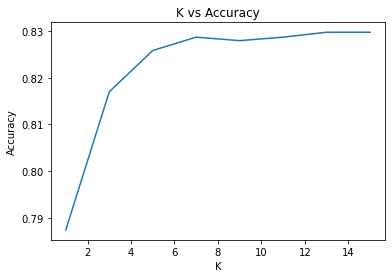

In [112]:
# Graph classification accuracy over k
plt.plot(ks, acc)
plt.title("K vs Accuracy")
plt.xlabel("K")
plt.ylabel("Accuracy")
print(acc)
plt.show()

# For the rest of the experiments use only normalized data

## 3. (10%) Use the regression variation of your algorithm (without distance weighting) for the [housing price prediction](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) problem.

- Use this [training set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_train.arff) and this [test set](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/housing_test.arff).
- Use Mean Square Error (MSE) on the test set as your accuracy metric for this case.
    - Do not normalize regression output values
- Graph MSE on the test set with odd values of k from 1 to 15


In [166]:
# Load housing price prediction data
house_train = arff.loadarff("housing_train.arff")
house_train_df = pd.DataFrame(house_train[0])
house_train_df['CHAS'] = house_train_df['CHAS'].str.decode('utf-8')
house_train_df['CHAS'] = house_train_df['CHAS'].astype(float)
tar = house_train_df['MEDV']
temp = house_train_df.drop(columns=['MEDV'])
norm_house_train_df = (temp - temp.min()) / (temp.max() - temp.min())
norm_house_train_df['MEDV'] = tar
norm_house_train_np = np.array(norm_house_train_df)
norm_X_train, norm_y_train = norm_house_train_np[:,:-1], norm_house_train_np[:,-1]

house_test = arff.loadarff("housing_test.arff")
house_test_df = pd.DataFrame(house_test[0])
house_test_df['CHAS'] = house_test_df['CHAS'].str.decode('utf-8')
house_test_df['CHAS'] = house_test_df['CHAS'].astype(float)
tar = house_test_df['MEDV']
temp = house_test_df.drop(columns=['MEDV'])
norm_house_test_df = (temp - temp.min()) / (temp.max() - temp.min())
norm_house_test_df['MEDV'] = tar
norm_house_test_np = np.array(norm_house_test_df)
norm_X_test, norm_y_test = norm_house_test_np[:,:-1], norm_house_test_np[:,-1]

In [85]:
# Train/Predict using k=1,3,...,15
ks = np.arange(1,17,2)
house_norm_knn = KNNClassifier(weight_type='no_weight', regression=True)
house_norm_knn = house_norm_knn.fit(norm_X_train, norm_y_train)

mse = []
for k in ks:
    m = mean_squared_error(norm_y_test, house_norm_knn.predict(norm_X_test, k))
    mse.append(m)

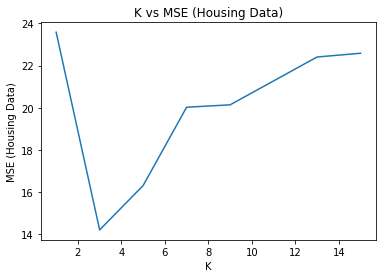

In [89]:
# Graph MSE over k
plt.plot(ks, mse)
plt.title("K vs MSE (Housing Data)")
plt.xlabel("K")
plt.ylabel("MSE (Housing Data)")
plt.show()

## 4. (15%) Repeat your experiments for magic telescope and housing using distance-weighted (inverse of distance squared) voting and discuss your results.


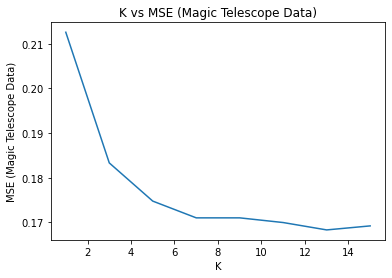

In [121]:
# Train/Predict magic telescope using distance-weighted voting
magic_d_knn = KNNClassifier(weight_type="inverse_distance", regression=False)
magic_d_knn = magic_d_knn.fit(magic_X_train_norm, magic_y_train_norm)
mse = []
for k in ks:
    m = mean_squared_error(LabelEncoder().fit_transform(magic_y_test_norm), LabelEncoder().fit_transform(magic_d_knn.predict(magic_X_test_norm, k)))
    mse.append(m)
plt.plot(ks, mse)
plt.title("K vs MSE (Magic Telescope Data)")
plt.xlabel("K")
plt.ylabel("MSE (Magic Telescope Data)")
plt.show()

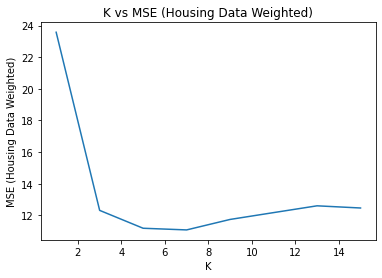

In [128]:
# Train/Predict housing using distance-weighted voting
house_d_knn = KNNClassifier(weight_type="inverse_distance", regression=True)
house_d_knn = house_d_knn.fit(norm_X_train, norm_y_train)
mse = []
for k in ks:
    m = mean_squared_error(norm_y_test, house_d_knn.predict(norm_X_test, k))
    mse.append(m)
plt.plot(ks, mse)
plt.title("K vs MSE (Housing Data Weighted)")
plt.xlabel("K")
plt.ylabel("MSE (Housing Data Weighted)")
plt.show()

For the magic telescope data, the mean squared error was the lowest around 13 as k value. For the housing data, however, I got the lowest mean squared error when k was 6 or 7 for the regression problem. MSE was high when I used the unnormalized data for the housing prediction model, but it was much lower when I used the normalized data, and the best k value was also different between those two models.

## 5. (10%) Use the k-nearest neighbor algorithm to solve the [credit-approval](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) (credit-a) problem.

- Use this [dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/credit_approval.arff)
    - Use a 70/30 split of the data for the training/test set
- Note that this set has both continuous and nominal attributes, together with don’t know values. 
- Implement and justify a distance metric which supports continuous, nominal, and don’t know attribute values
    - You need to handle don't knows with the distance metric, not by imputing a value.
    - More information on distance metrics can be found [here](https://www.jair.org/index.php/jair/article/view/10182/24168).
- Use your own choice for k.
- As a rough sanity check, typical knn accuracies for the credit data set are 70-80%.


In [144]:
# Load dataset and split into train/test sets
credit = arff.loadarff("credit_approval.arff")
credit_df = pd.DataFrame(credit[0])
str_df = credit_df.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    credit_df[col]=str_df[col]
    
# normalize
temp = credit_df[["A2","A3","A8","A11","A14","A15"]]
temp = (temp - temp.min()) / (temp.max() - temp.min())
credit_df[["A2","A3","A8","A11","A14","A15"]] = temp
#credit_df = credit_df.replace(['?'], np.nan)
#credit_df.fillna('?')
credit_train_np = np.array(credit_df)
X,y = credit_train_np[:,:-1], credit_train_np[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)  
    
col_types = ["cat","num","num","cat","cat","cat","cat","num","cat","cat","num","cat","cat","num","num"] # without output class
credit_knn = KNNClassifier(col_types, weight_type="mixed")
credit_knn = credit_knn.fit(X_train, y_train)
p = credit_knn.predict(X_test, 3)
# Train/Predict credit-approval

print(credit_knn.score(X_test, y_test, 7))

0.8743961352657005


*Explain and justify your distance metric*

I used Heterogeneous Euclidean-Overlap Metric (HEOM) to deal with both continuous and nominal values.
First, if an attribute is categorical, the algorithm returns 0 if they are the same class, otherwise 1.
Second, if numerical, it computes the range-normalized difference as explained in the paper. 
Lastly, if there is a missing value, it returns a maximum distance which is 1, and calcualte the sum of the squared result vector.

I explored some different k values and found that 7 gave the best result of about 87%. 

## 6. (15%) Use the scikit's KNN Classifier on magic telescope and KNN Regressor on housing and compare your results.

- Try out different hyperparameters to see how well you can do. 


In [198]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

# Train/Predict magic telescope using scikit's KNN
np_magic = np.array(norm_magic_train_df)
X,y = np_magic[:,:-1], np_magic[:,-1]
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.2)

neigh = KNeighborsClassifier(n_neighbors=8, weights="distance")
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
print("Magic telescope Accuracy: ", metrics.accuracy_score(y_test, pred))

# Train/Predict housing using scikit's KNN
neigh = KNeighborsRegressor(n_neighbors=5, weights="distance", algorithm="kd_tree")
neigh.fit(norm_X_train, norm_y_train)
pred = neigh.predict(norm_X_test)
print("Housing Data Accuracy: ", neigh.score(norm_X_test, norm_y_test))

Magic telescope Accuracy:  0.8288142452448402
Housing Data Accuracy:  0.8285306817927963


*Report your comparison*
For the magic telescope data, I got pretty the same result as that from sklearn classifier. I tried different weightings, neighbors, and other algorithms for the regression problem.
The accuracy for the housing data was also similar to the one that I implemented. For both datasets, the accuracies were about 83% each.

## 7. (optional 5% extra credit): For the best value of k for any one of the datasets, implement a reduction algorithm that removes data points in some rational way such that performance does not drop too drastically on the test set given the reduced training set.

- Compare your performance on the test set for the reduced and non-reduced versions and give the number (and percentage) of training examples removed from the original training set. How well does your reduction algorithm work?
    - Note that performance for magic telescope is classification accuracy and for housing it is mean squared error.
    - Magic Telescope has about 12,000 instances and if you use a leave one out style of testing for your data set reduction, then your algorithm will run slow since that is n2 at each step.
    - If you wish, you may use a random subset of 2,000 of the magic telescope instances.
    - More information on reduction techniques can be found [here](http://axon.cs.byu.edu/~martinez/classes/478/slides/IBL.pdf).
